## Setup

In [90]:
%matplotlib inline

In [91]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [92]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [93]:
sys.argv = ['']
args = vars(ap.parse_args())

In [94]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [95]:
DATASET = "compas_race"
BASELINE = "mlp" 
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = 1
ATTACK = "mia2"

In [96]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

In [97]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [98]:
DATASET

'compas_race'

In [99]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

Inside load_data(), self.DATASET = compas_race


In [100]:
df, _ = dataset_orig.convert_to_dataframe()
df[['race', 'two_year_recid']].value_counts()

race  two_year_recid
0.0   0.0               2082
0.0   1.0               1987
1.0   0.0               1281
1.0   1.0                822
Name: count, dtype: int64

In [101]:
dataset_orig.features.shape

(6172, 10)

In [102]:
privileged_groups

[{'race': 1}]

In [103]:
sens_attr

'race'

In [104]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [105]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [106]:
seed = 1234
np.random.seed(seed)

In [107]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [108]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [109]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [110]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [111]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [112]:
df, _ = dataset_orig.convert_to_dataframe()

In [113]:
# target_dataset = None
# reference_dataset = None

In [114]:
import warnings
warnings.filterwarnings("ignore")

In [115]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [116]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 740
Number of test points: 740
Number of population points: 1851
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  259.0 481.0
base_pos unpriv:  0.48440748440748443
base_pos priv:  0.38996138996138996
DIFFERENCE IS GOOD
base_pos unpriv:  0.48440748440748443
base_pos priv:  0.38996138996138996
no bias type specified
#### Training Dataset shape
(740, 10)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc']
number of favorable labels:  334
Difference in mean outcomes between unprivileged and privileged groups = 0.094446
#### Train shape, validat

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.5531974]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: [0.56828489]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 248, Test = 251
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.93093222]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 233, Test = 221
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy 

Best thresh:  [0.49914673]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.68878455]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 261, Test = 242
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.69564507]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 229, Test = 234
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.01
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.09
  Positive predictive value: 0.67
  Optimal thershold: [0.67669706]
)
MIA_Result(
  Name: subpopulation_1.0_la

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.55728705]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.26
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.55728705]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 261, Test = 242
  AUC: 0.48
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.06
  Positive predictive value: 0.64
  Optimal thershold: [0.8374489]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 229, Test = 234
  AUC: 0.54
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.28
  Attacker adv


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.43902439024390244
after transf unpriv:  0.47368421052631576
Difference in mean outcomes between unprivileged and privileged groups = 0.034660
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.65905662]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.04
  Positive predictive value: 0.67
  Optimal thershold: [0.46478847]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 260, Test = 264
  AUC: 0.48
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.34216167]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: [0.97118188]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 260, Test = 264
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.02
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.93923525]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 234, Test = 218
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy

origin, transf:  740 740
after transf priv:  0.38271604938271603
after transf unpriv:  0.5030181086519114
Difference in mean outcomes between unprivileged and privileged groups = 0.120302
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.33071484]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.41379559]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 247, Test = 237
  AUC: 0.49
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.09
  Positive predictive value: 1.00
  Optim

Best thresh:  [0.34027731]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.42199253]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 247, Test = 237
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.09
  Positive predictive value: 1.00
  Optimal thershold: [0.94314632]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 250, Test = 235
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.09
  Positive predictive value: 1.00
  Optimal thershold: [0.43288129]
)
MIA_Result(
  Name: subpopulation_1.0_la


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.34099616858237547
after transf unpriv:  0.4989561586638831
Difference in mean outcomes between unprivileged and privileged groups = 0.157960
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.32793781]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [1.05924007]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 240, Test = 258
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0

Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.50079729]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.07
  Positive predictive value: 0.62
  Optimal thershold: [0.67966748]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 240, Test = 258
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.10
  Positive predictive value: 1.00
  Optimal thershold: [0.6775389]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 239, Test = 237
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.06
  Positive predictive value: 0.78
  Optimal 

Best thresh:  [0.57268132]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.63440714]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 236, Test = 272
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.54
  Train Accuracy (TPR): 0.03
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.06
  Positive predictive value: 0.62
  Optimal thershold: [0.90456774]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 265, Test = 229
  AUC: 0.50
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.53924812]
)
MIA_Result(
  Name: subpopulation_1.0_la

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.49811833]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.06
  Positive predictive value: 0.62
  Optimal thershold: [0.55219843]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 236, Test = 272
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.54
  Train Accuracy (TPR): 0.03
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.91317377]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 265, Test = 229
  AUC: 0.51
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy

Best thresh:  [0.53918265]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.04
  Positive predictive value: 0.80
  Optimal thershold: [0.65838355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 240, Test = 256
  AUC: 0.47
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.05
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.06
  Positive predictive value: 0.60
  Optimal thershold: [0.6998344]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 237, Test = 235
  AUC: 0.47
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [0.64965878]
)
MIA_Result(
  Name: subpopulation_1.0_lab

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.53263954]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.05
  Positive predictive value: 0.80
  Optimal thershold: [0.59142706]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 240, Test = 256
  AUC: 0.44
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.07
  Test Accuracy (TNR): 0.95
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.70667502]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 237, Test = 235
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.26
  Attacker ad

Best thresh:  [0.59102689]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.79840735]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 257
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.54
  Train Accuracy (TPR): 0.07
  Test Accuracy (TNR): 0.97
  Attacker advantage: 0.08
  Positive predictive value: 0.71
  Optimal thershold: [0.84082914]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 240, Test = 261
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.03
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.59474449]
)
MIA_Result(
  Name: subpopulation_1.0_la

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.57744656]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: [0.79116978]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 237, Test = 257
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.54
  Train Accuracy (TPR): 0.07
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.83437421]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 240, Test = 261
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.02
  Test Accuracy (TNR): 0.98
  Attacker ad

Best thresh:  [0.61424525]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.14
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.47637195]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 251, Test = 252
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.8995311]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 251, Test = 232
  AUC: 0.51
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.08
  Positive predictive value: 1.00
  Optimal thershold: [0.47702085]
)
MIA_Result(
  Name: subpopulation_1.0_lab

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.34083543]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: [0.46095294]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 251, Test = 252
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [1.22303513]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 251, Test = 232
  AUC: 0.44
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker ad

Best thresh:  [0.32664228]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.26
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.42053212]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 236, Test = 257
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.53
  Train Accuracy (TPR): 0.03
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.06
  Positive predictive value: 0.88
  Optimal thershold: [0.95412566]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 246, Test = 226
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.43068275]
)
MIA_Result(
  Name: subpopulation_1.0_la

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.33512014]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 0.60
  Optimal thershold: [1.0510154]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 236, Test = 257
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.11
  Positive predictive value: 0.89
  Optimal thershold: [1.05200253]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 246, Test = 226
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy 

Best thresh:  [0.32735418]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.94878849]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 245
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [1.17030891]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 242, Test = 255
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.38184803]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [0.33648301]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.43407098]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 245
  AUC: 0.50
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [1.19176742]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 242, Test = 255
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.10
  Positive predictive value: 1.00
  Optimal thershold: [0.43010473]
)
MIA_Result(
  Name: subpopulation_1.0_la

Best thresh:  [0.33005685]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.46430582]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 239, Test = 257
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.53
  Train Accuracy (TPR): 0.05
  Test Accuracy (TNR): 0.96
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [1.20240433]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 252, Test = 240
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.35175632]
)
MIA_Result(
  Name: subpopulation_1.0_la

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.34000334]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [1.03372911]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 239, Test = 257
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.28
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.09
  Positive predictive value: 0.73
  Optimal thershold: [1.0342198]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 252, Test = 240
  AUC: 0.48
  Privacy Risk: 0.53
  Accuracy: 0.52
  Train Accuracy 

Best thresh:  [0.52166552]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.89628702]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 222, Test = 219
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.89534259]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 242, Test = 243
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.45590733]
)
MIA_Result(
  Name: subpopulation_1.0_la

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.52448361]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.68
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.59451305]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 222, Test = 219
  AUC: 0.45
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.12
  Positive predictive value: 0.51
  Optimal thershold: [0.87971173]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 242, Test = 243
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.39166666666666666
after transf unpriv:  0.488
Difference in mean outcomes between unprivileged and privileged groups = 0.096333
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.60135065]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.03
  Positive predictive value: 0.80
  Optimal thershold: [0.70290149]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 256, Test = 248
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 1.00
  Test Ac

Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.56922247]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.94
  Attacker advantage: 0.03
  Positive predictive value: 0.60
  Optimal thershold: [0.48675377]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 256, Test = 248
  AUC: 0.47
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: [0.89801867]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 244, Test = 230
  AUC: 0.50
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.28
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.08
  

Results are stored in: ['un_log_pop']
TEST
Checking predict proba
Best thresh:  [0.5826805]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.68472784]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 226, Test = 269
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.55
  Train Accuracy (TPR): 0.04
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.84263524]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 233
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal t

Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.59171451]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.09
  Positive predictive value: 0.53
  Optimal thershold: [0.84323656]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 226, Test = 269
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.60
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.17
  Positive predictive value: 0.80
  Optimal thershold: [0.83997051]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 233
  AUC: 0.45
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.10
  Positive predictive value: 0.51
  Optimal

Best thresh:  [0.3301647]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.49936831]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 217, Test = 254
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.55
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [1.05276613]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 251, Test = 225
  AUC: 0.48
  Privacy Risk: 0.53
  Accuracy: 0.55
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.10
  Positive predictive value: 1.00
  Optimal thershold: [0.44240702]
)
MIA_Result(
  Name: subpopulation_1.0_lab

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.34145449]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.50090529]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 217, Test = 254
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.55
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: [1.0765888]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 251, Test = 225
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.54
  Train Accuracy 


------------------------------

[INFO] Random Oversampling ......

------------------------------

origin, transf:  740 740
after transf priv:  0.3540856031128405
after transf unpriv:  0.5341614906832298
Difference in mean outcomes between unprivileged and privileged groups = 0.180076
[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['syn_log_group']
Results are stored in: ['syn_log_pop']
TEST
Checking predict proba
Best thresh:  [0.32750221]
Testing Syn OR Rew ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.06
  Positive predictive value: 1.00
  Optimal thershold: [0.96890249]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 225, Test = 254
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.56
  Train Accuracy (TPR): 0.

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.33606419]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.06
  Positive predictive value: 0.75
  Optimal thershold: [1.01060368]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 225, Test = 254
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.59
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.94
  Attacker advantage: 0.13
  Positive predictive value: 1.00
  Optimal thershold: [1.01696612]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 258, Test = 226
  AUC: 0.44
  Privacy Risk: 0.49
  Accuracy: 0.53
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.00
  Attacker ad

Best thresh:  [0.47788239]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.04
  Positive predictive value: 1.00
  Optimal thershold: [0.68553665]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 244, Test = 258
  AUC: 0.50
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.08
  Positive predictive value: 0.62
  Optimal thershold: [0.68120918]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 225
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.10
  Positive predictive value: 1.00
  Optimal thershold: [0.58244262]
)
MIA_Result(
  Name: subpopulation_1.0_la

RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.48812651]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.05
  Positive predictive value: 1.00
  Optimal thershold: [0.67130697]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 244, Test = 258
  AUC: 0.47
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.02
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.06
  Positive predictive value: 0.80
  Optimal thershold: [0.6702105]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 241, Test = 225
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.52
  Attacker adv

Best thresh:  [0.32641218]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [1.08638754]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 259
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.04
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.04
  Positive predictive value: 0.69
  Optimal thershold: [1.09201634]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 214, Test = 240
  AUC: 0.47
  Privacy Risk: 0.50
  Accuracy: 0.53
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.05
  Positive predictive value: 0.47
  Optimal thershold: [0.32641218]
)
MIA_Result(
  Name: subpopulation_1.0_la

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.34099577]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.04
  Positive predictive value: 0.86
  Optimal thershold: [1.07276599]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 250, Test = 259
  AUC: 0.48
  Privacy Risk: 0.51
  Accuracy: 0.52
  Train Accuracy (TPR): 0.04
  Test Accuracy (TNR): 0.98
  Attacker advantage: 0.08
  Positive predictive value: 0.69
  Optimal thershold: [1.08682962]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 214, Test = 240
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.54
  Train Accuracy

Best thresh:  [0.5769605]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.07
  Positive predictive value: 0.75
  Optimal thershold: [0.74172818]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 234, Test = 277
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.07
  Positive predictive value: 1.00
  Optimal thershold: [0.84415803]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 259, Test = 240
  AUC: 0.51
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.75
  Optimal thershold: [0.45360579]
)
MIA_Result(
  Name: subpopulation_1.0_lab

[INFO]: training differentially private random forest
RUN MIA2 ATTACK
Results are stored in: ['dir_log_group']
Results are stored in: ['dir_log_pop']
TEST
Checking predict proba
Best thresh:  [0.55423926]
Testing Original ...
TEST
Checking predict proba
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.07
  Positive predictive value: 0.75
  Optimal thershold: [0.74062907]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 234, Test = 277
  AUC: 0.48
  Privacy Risk: 0.50
  Accuracy: 0.55
  Train Accuracy (TPR): 0.02
  Test Accuracy (TNR): 0.99
  Attacker advantage: 0.06
  Positive predictive value: 0.67
  Optimal thershold: [0.82746038]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 259, Test = 240
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy

## Feature Analysis

In [117]:
# # Dictionary to store SHAP values
# shap_results = {
#     "orig": orig_metrics['shap_values'],
#     "transf": transf_metrics['shap_values'],
#     "dir": dir_metrics['shap_values'],
#     "reweigh": reweigh_metrics['shap_values'],
#     "eg": eg_metrics['shap_values']
# }

In [118]:
# shap_results = pd.DataFrame.from_dict(shap_results)

In [119]:
# # File path
# today = datetime.now().strftime('%Y-%m-%d')
# file_path = f"./mia2_results/rf_{ATTACK}_{DATASET}_shap_values_{today}.csv"

# # Save to CSV
# shap_results.to_csv(file_path, index=True)

# file_path

## Display Output

In [120]:
priv_metric_orig_copy = priv_metric_orig

In [121]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 5113.0, 'total_unpriv': 9687.0})

In [122]:
priv_metric_orig

defaultdict(float, {'total_priv': 5113.0, 'total_unpriv': 9687.0})

In [123]:
priv_metric_orig.items()

dict_items([('total_priv', 5113.0), ('total_unpriv', 9687.0)])

In [124]:
priv_metric_orig = priv_metric_orig_copy

In [125]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

compas_race
740
2)

              total_priv  total_unpriv
num_instance                          
orig              255.65        484.35
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.463311       0.536689    0.389033      0.610967       0.50257   
transf      0.463311       0.536689    0.389033      0.610967       0.50257   

         unpriv_unfavor  
dataset                  
orig            0.49743  
transf          0.49743  


# Train/Test Accuracies

In [126]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [127]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [128]:
def calculate_mean_std_accuracy(acc_metrics):
    mean_std_accuracies = {
        key: {
            "mean": sum(values) / len(values),
            "std": statistics.stdev(values) if len(values) > 1 else 0  # Avoid error if only one value
        }
        for key, values in acc_metrics.items()
    }
    return mean_std_accuracies

In [129]:
orig_acc_stats = calculate_mean_std_accuracy(orig_acc)
transf_acc_stats = calculate_mean_std_accuracy(transf_acc)
reweigh_acc_stats = calculate_mean_std_accuracy(reweigh_acc)
dir_acc_stats = calculate_mean_std_accuracy(dir_acc)
eg_acc_stats = calculate_mean_std_accuracy(eg_acc)

In [130]:
# Convert dictionary to DataFrame with mean and std
train_test_data = {
    "orig_acc_mean": {key: value["mean"] for key, value in orig_acc_stats.items()},
    "orig_acc_std": {key: value["std"] for key, value in orig_acc_stats.items()},
    "transf_acc_mean": {key: value["mean"] for key, value in transf_acc_stats.items()},
    "transf_acc_std": {key: value["std"] for key, value in transf_acc_stats.items()},
    "reweigh_acc_mean": {key: value["mean"] for key, value in reweigh_acc_stats.items()},
    "reweigh_acc_std": {key: value["std"] for key, value in reweigh_acc_stats.items()},
    "dir_acc_mean": {key: value["mean"] for key, value in dir_acc_stats.items()},
    "dir_acc_std": {key: value["std"] for key, value in dir_acc_stats.items()},
    "eg_acc_mean": {key: value["mean"] for key, value in eg_acc_stats.items()},
    "eg_acc_std": {key: value["std"] for key, value in eg_acc_stats.items()},
}

## Save Data

In [131]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./nn_mia2_results/mlp_mia2_compas_race_train_test_accuracies_2025-03-25.csv'

In [132]:
train_test_df

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,0.058583,0.143498,0.058583,0.143498,0.106917,0.236170,0.045402,0.115646,0.072973,0.215920
accuracy_train_0_+,0.970879,0.074251,0.970879,0.074251,0.934049,0.153258,0.979011,0.056932,0.946024,0.160259
accuracy_train_1_-,0.398540,0.445054,0.398540,0.445054,0.272089,0.421866,0.424157,0.441174,0.072140,0.213435
accuracy_train_1_+,0.630391,0.426419,0.630391,0.426419,0.752106,0.396576,0.602622,0.424110,0.946637,0.154799
accuracy_test_0_-,0.052559,0.128328,0.052559,0.128328,0.099974,0.222298,0.048644,0.121920,0.072231,0.211619
accuracy_test_0_+,0.970227,0.074143,0.970227,0.074143,0.929978,0.165529,0.973842,0.072450,0.948672,0.158263
accuracy_test_1_-,0.395209,0.445104,0.395209,0.445104,0.259916,0.409496,0.423876,0.440042,0.073862,0.216960
accuracy_test_1_+,0.605905,0.432280,0.605905,0.432280,0.750188,0.394440,0.584303,0.426382,0.942937,0.174105
accuracy_train,0.508919,0.058072,0.508919,0.058072,0.501216,0.063979,0.509527,0.054494,0.477027,0.042454
accuracy_test,0.487838,0.051893,0.487838,0.051893,0.484527,0.053675,0.489054,0.048104,0.464865,0.047852


In [133]:
train_test_df.head()

,orig_acc_mean,orig_acc_std,transf_acc_mean,transf_acc_std,reweigh_acc_mean,reweigh_acc_std,dir_acc_mean,dir_acc_std,eg_acc_mean,eg_acc_std
accuracy_train_0_-,0.058583,0.143498,0.058583,0.143498,0.106917,0.236170,0.045402,0.115646,0.072973,0.215920
accuracy_train_0_+,0.970879,0.074251,0.970879,0.074251,0.934049,0.153258,0.979011,0.056932,0.946024,0.160259
accuracy_train_1_-,0.398540,0.445054,0.398540,0.445054,0.272089,0.421866,0.424157,0.441174,0.072140,0.213435
accuracy_train_1_+,0.630391,0.426419,0.630391,0.426419,0.752106,0.396576,0.602622,0.424110,0.946637,0.154799
accuracy_test_0_-,0.052559,0.128328,0.052559,0.128328,0.099974,0.222298,0.048644,0.121920,0.072231,0.211619


In [134]:
# feature_importance_df = pd.DataFrame(orig_metrics["feature_importances"])  # Extract feature importance across runs
# feature_importance_df

In [135]:
orig_metrics

defaultdict(list,
            {'bal_acc': [0.5360466494768976,
              0.5890613451589062,
              0.5316730979412486,
              0.5,
              0.5,
              0.5570599037911061,
              0.5908191589888967,
              0.5692742591900037,
              0.5523529411764706,
              0.5,
              0.5,
              0.5,
              0.5938011456628478,
              0.5492463531436895,
              0.5583557921464686,
              0.5,
              0.5,
              0.5875151272171117,
              0.5,
              0.5663021316033364],
             'disp_imp': [1.0,
              1.0,
              0.7438230795156984,
              0.0,
              0.0,
              1.0,
              1.0,
              1.0,
              1.0,
              0.0,
              0.0,
              0.0,
              0.9938449240607514,
              1.0,
              1.0,
              0.0,
              0.0,
              0.9863152128744664,
           

In [136]:
# del orig_metrics['shap_values']
# del transf_metrics['shap_values']
# del reweigh_metrics['shap_values']
# del dir_metrics['shap_values']
# del eg_metrics['shap_values']

In [137]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

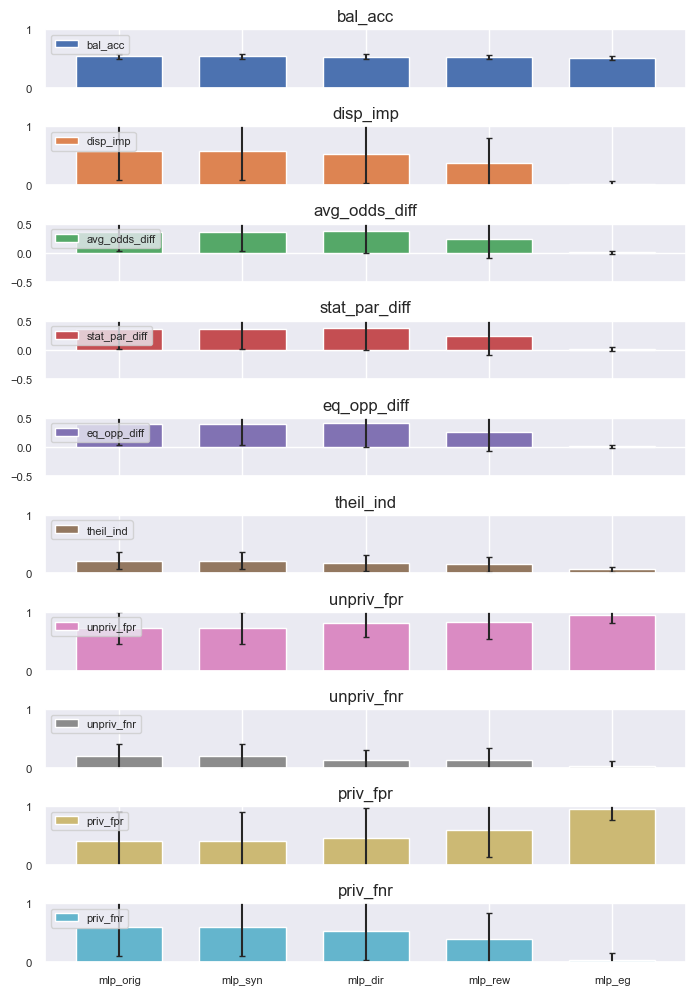

In [138]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [139]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./nn_mia2_results/mlp_mia2_compas_race_fairness_metrics_2025-03-25.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [140]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [141]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           orig_mia_error_metrics,
           transf_mia_metrics_mean,
           transf_mia_error_metrics,
           dir_mia_metrics_mean,
           dir_mia_error_metrics,
           reweigh_mia_metrics_mean,
           reweigh_mia_error_metrics,
           eg_mia_metrics_mean,
           eg_mia_error_metrics
          ]

index = pd.Series(['orig'] + ['orig_std'] + ['syn'] + ['syn_std'] + ['dir'] + ['dir_std'] + ['rew'] + 
                  ['rew_std'] + ['eg'] + ['eg_std'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,0.518209,0.518278,0.518672,0.524750,0.531837
orig_std,0.007599,0.012103,0.016413,0.014633,0.027760
syn,0.518209,0.518278,0.518672,0.524750,0.531837
syn_std,0.007599,0.012103,0.016413,0.014633,0.027760
dir,0.523007,0.524264,0.528026,0.527289,0.537077
dir_std,0.008879,0.023231,0.022705,0.020718,0.031183
rew,0.517635,0.523095,0.516655,0.527662,0.534175
rew_std,0.009105,0.012322,0.013040,0.022665,0.027327
eg,0.516892,0.518015,0.520134,0.520274,0.528317


In [142]:
results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean,
          ]

errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

In [143]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [144]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [145]:
df_groups = df_groups.rename(columns={'subpopulation_0.0_label_0.0_mia_privacy_risk': 'G0-',
                           'subpopulation_1.0_label_0.0_mia_privacy_risk': 'G1-',
                           'subpopulation_0.0_label_1.0_mia_privacy_risk': 'G0+',
                           'subpopulation_1.0_label_1.0_mia_privacy_risk': 'G1+'})

In [146]:
df_groups

,G0-,G1-,G0+,G1+
Classifier MIA Attacks,,,,
orig,0.518278,0.524750,0.518672,0.531837
orig_std,0.012103,0.014633,0.016413,0.027760
syn,0.518278,0.524750,0.518672,0.531837
syn_std,0.012103,0.014633,0.016413,0.027760
dir,0.524264,0.527289,0.528026,0.537077
dir_std,0.023231,0.020718,0.022705,0.031183
rew,0.523095,0.527662,0.516655,0.534175
rew_std,0.012322,0.022665,0.013040,0.027327
eg,0.518015,0.520274,0.520134,0.528317


<Axes: xlabel='Classifier MIA Attacks'>

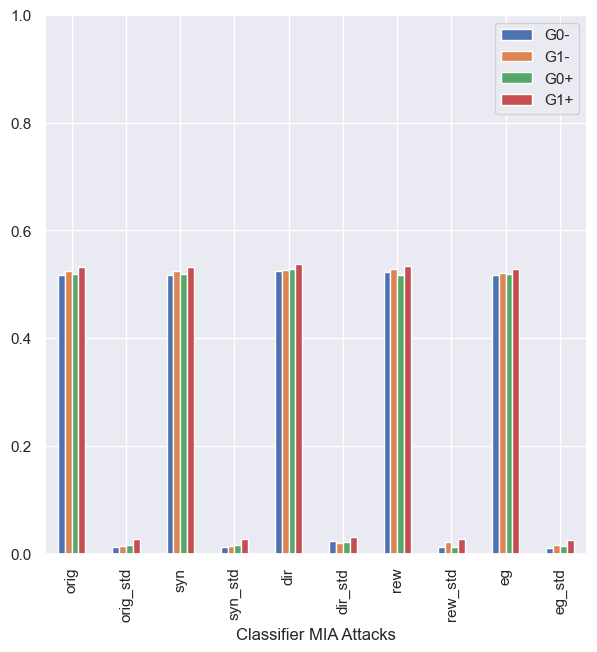

In [147]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [148]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

         orig    orig_std       syn    syn_std       dir    dir_std       rew    rew_std        eg     eg_std
---  --------  ----------  --------  ---------  --------  ---------  --------  ---------  --------  ---------
G0-  0.518278   0.0121027  0.518278  0.0121027  0.524264  0.0232306  0.523095  0.0123221  0.518015  0.0111287
G1-  0.52475    0.0146326  0.52475   0.0146326  0.527289  0.0207176  0.527662  0.0226645  0.520274  0.0164391
G0+  0.518672   0.0164134  0.518672  0.0164134  0.528026  0.0227047  0.516655  0.0130402  0.520134  0.0152971
G1+  0.531837   0.0277596  0.531837  0.0277596  0.537077  0.0311832  0.534175  0.0273267  0.528317  0.026624


## Save Results

In [149]:
errors

[{'entire_dataset_mia_privacy_risk': 0.007598604687893413,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.012102651717837845,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.0164134143735326,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.014632593279642806,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.02775963967405223},
 {'entire_dataset_mia_privacy_risk': 0.007598604687893413,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.012102651717837845,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.0164134143735326,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.014632593279642806,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.02775963967405223},
 {'entire_dataset_mia_privacy_risk': 0.008878943453246548,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.02323060138030008,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.022704688411726636,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.020717628731680583,
  'subpopulation_1.0_label_1.0_mia_p

In [150]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./nn_mia2_results/{BASELINE}_{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./nn_mia2_results/mlp_mia2_compas_race_mia_privacy_risks_metrics_2025-03-25.csv


# Main Bar Graph Visualization

In [151]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

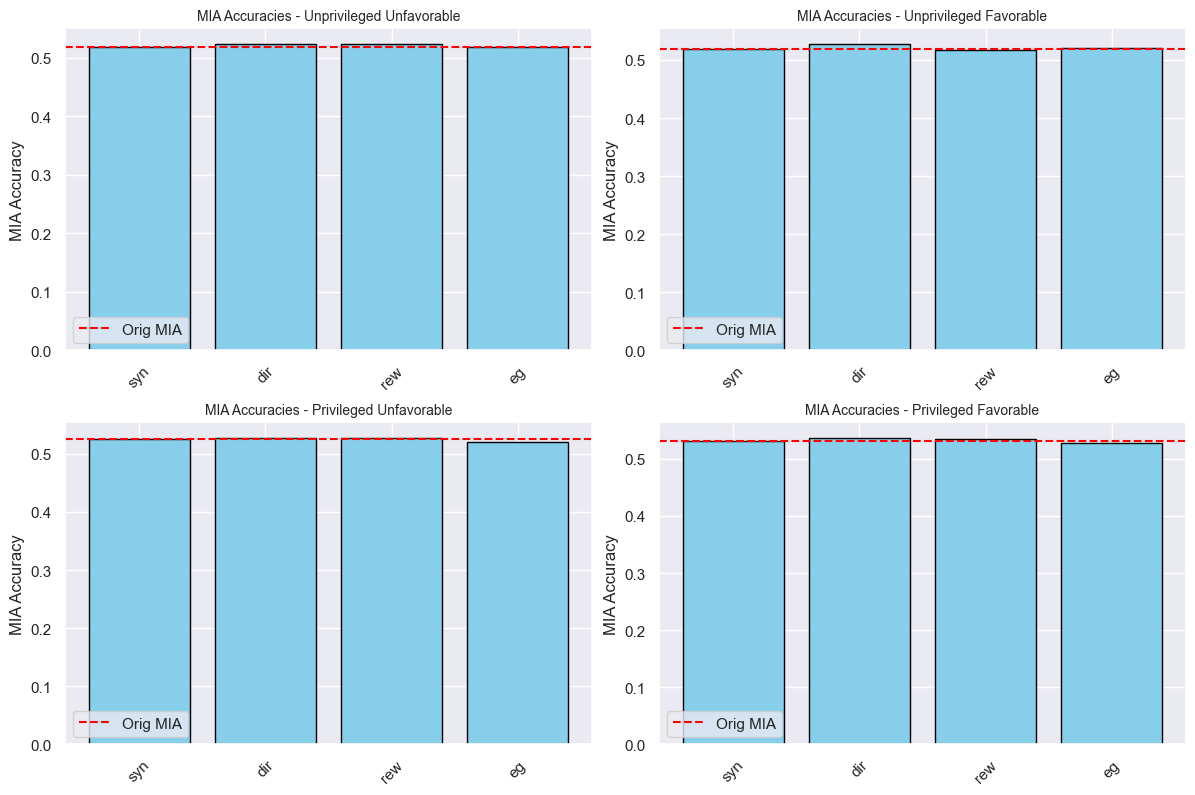

In [152]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [153]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [154]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [155]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.518919
1,orig,entire_dataset_mia_privacy_risk,0.509459
2,orig,entire_dataset_mia_privacy_risk,0.519595
3,orig,entire_dataset_mia_privacy_risk,0.514189
4,orig,entire_dataset_mia_privacy_risk,0.515541
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.512667
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.500859
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.530612
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.521603


In [156]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.518919
1,orig,entire_dataset_mia_privacy_risk,0.509459
2,orig,entire_dataset_mia_privacy_risk,0.519595
3,orig,entire_dataset_mia_privacy_risk,0.514189
4,orig,entire_dataset_mia_privacy_risk,0.515541
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.512667
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.500859
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.530612
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.521603


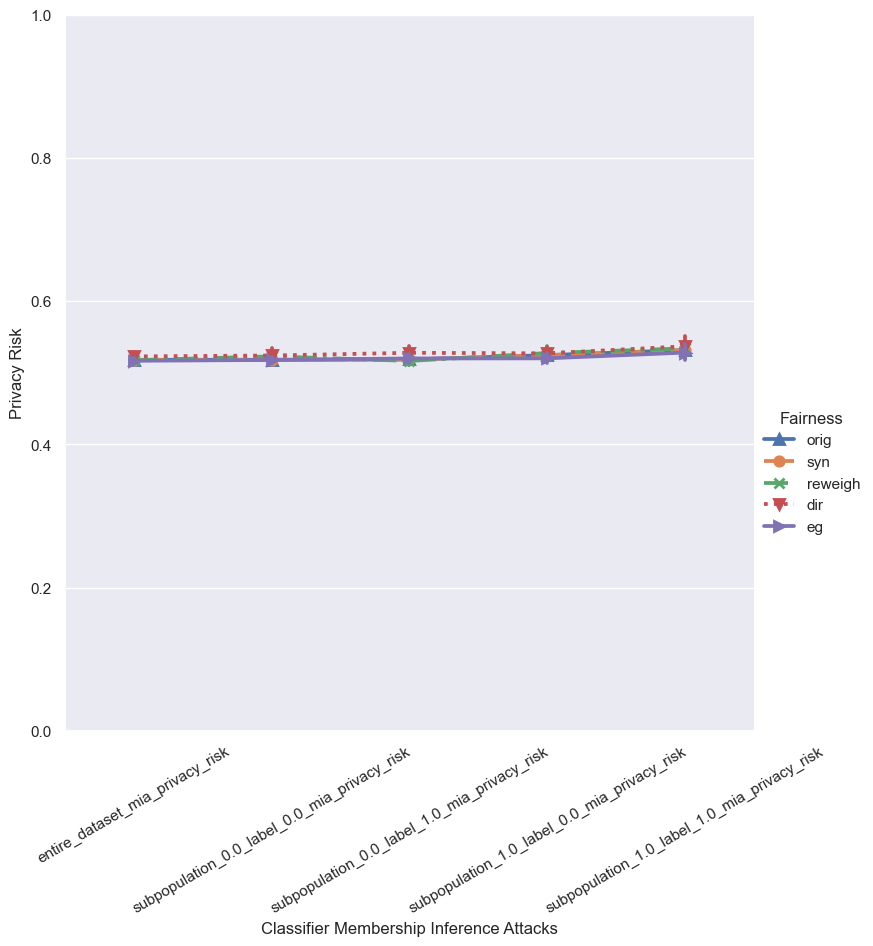

In [157]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [158]:
from sklearn.metrics import RocCurveDisplay, auc

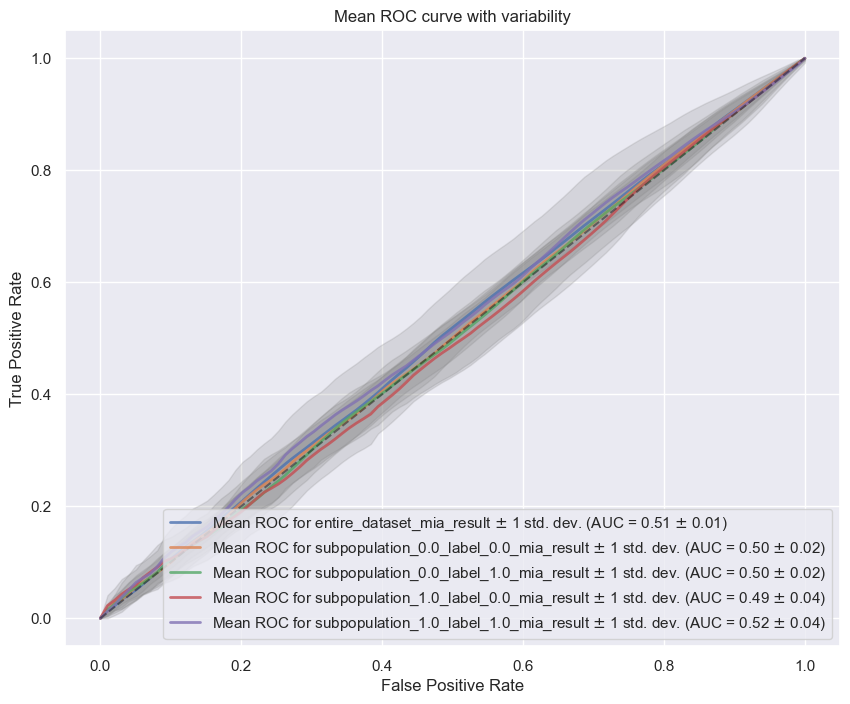

In [159]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.27
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: [0.57612546]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.03
  Positive predictive value: 1.00
  Optimal thershold: [0.68878455]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.04
  Positive predictive value: 0.67
  Optimal thershold: [0.46478847]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 740, Test = 740
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Ac

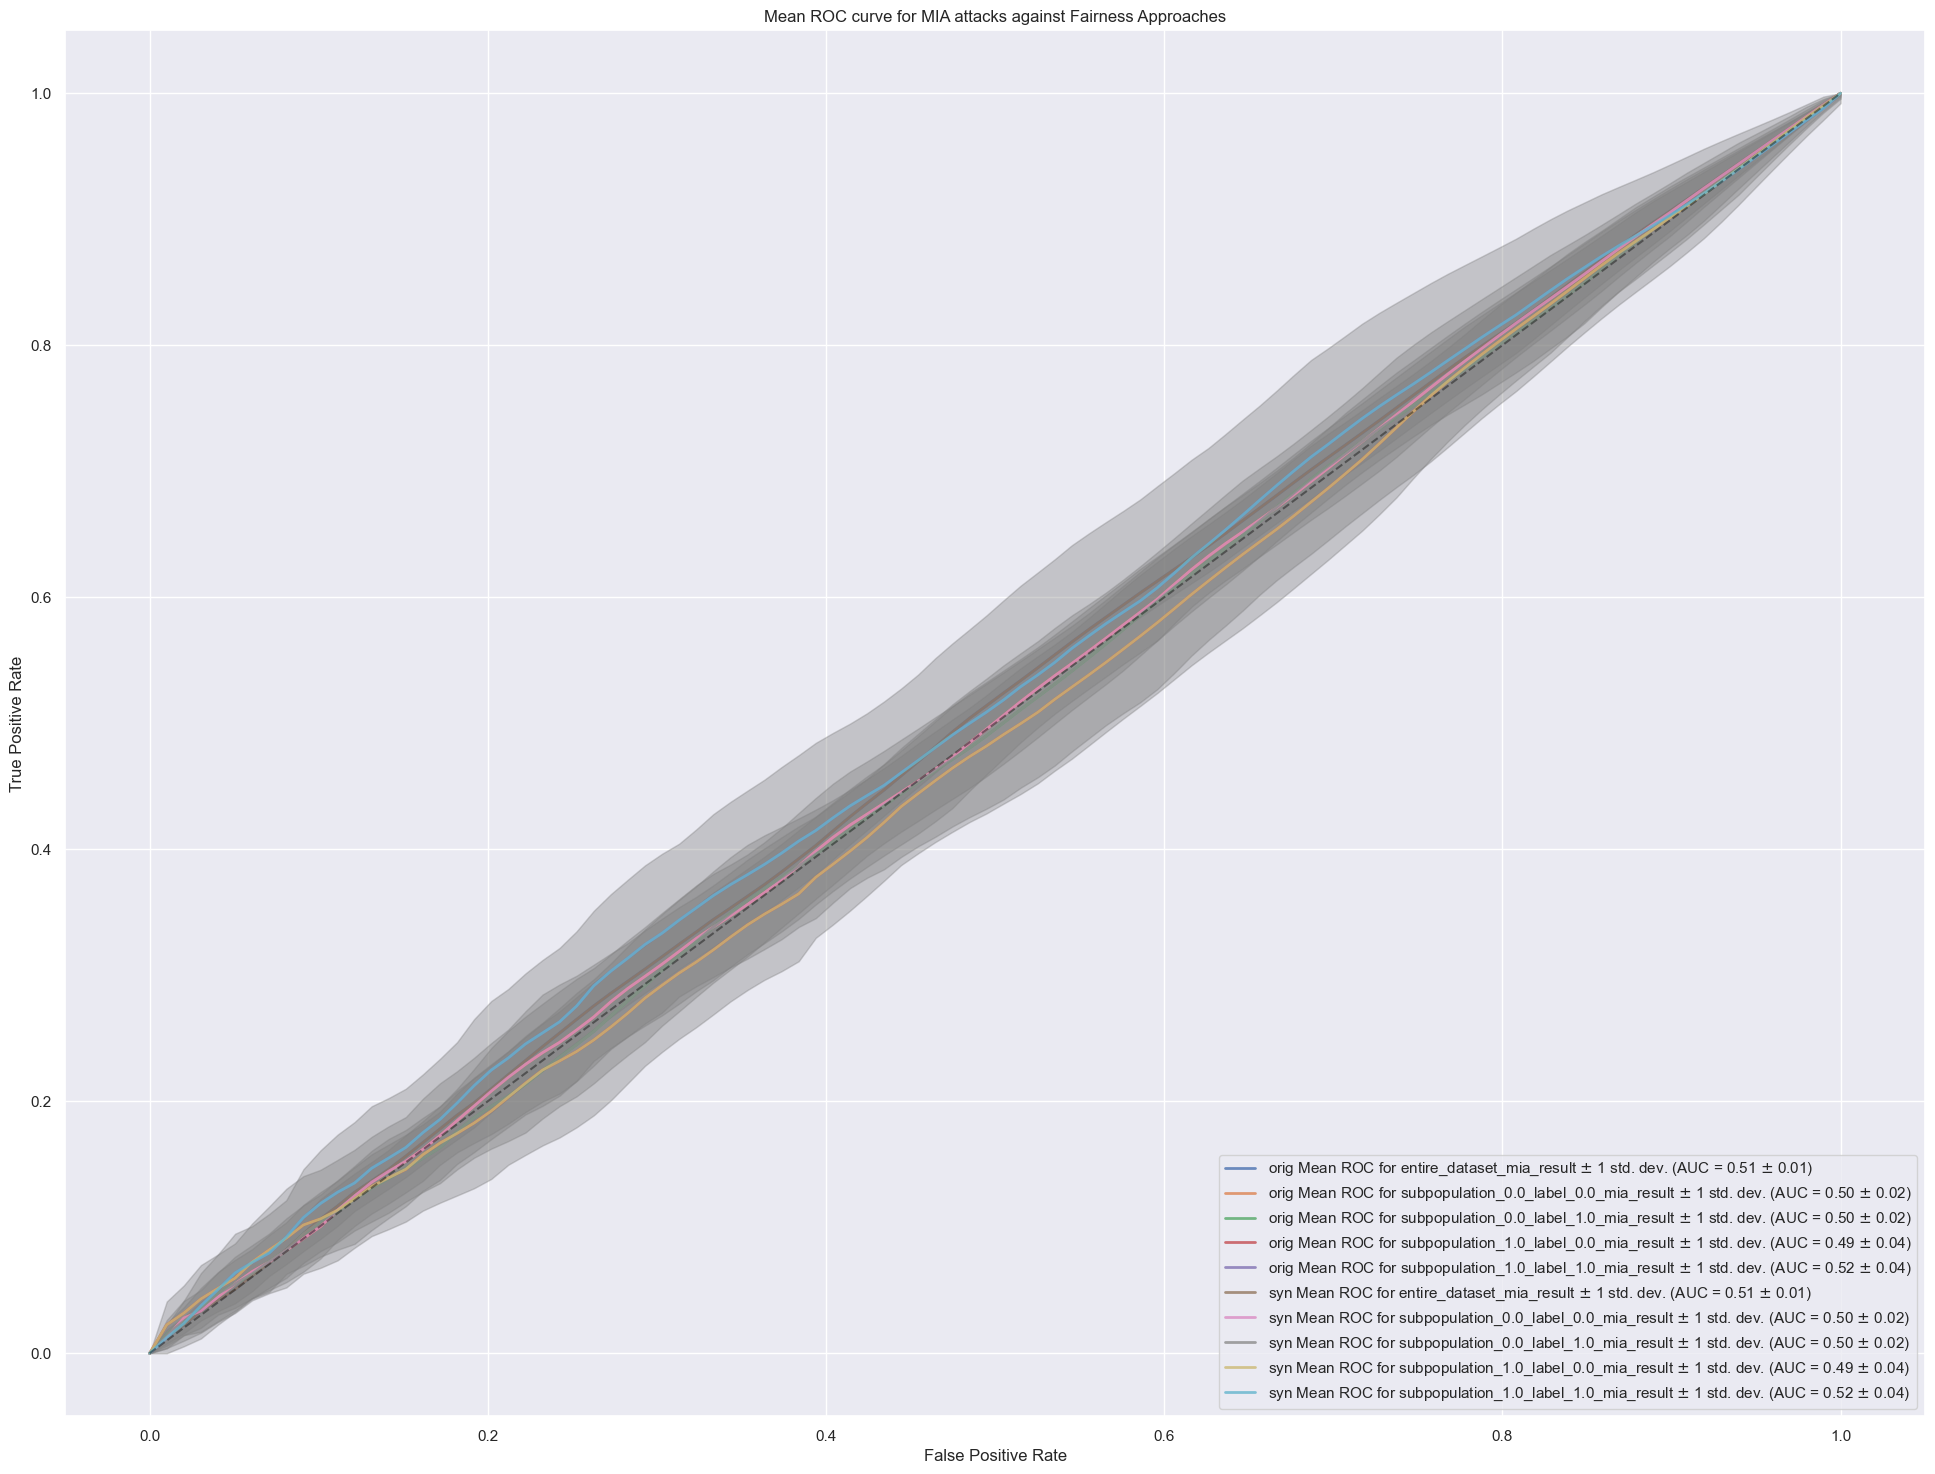

In [160]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

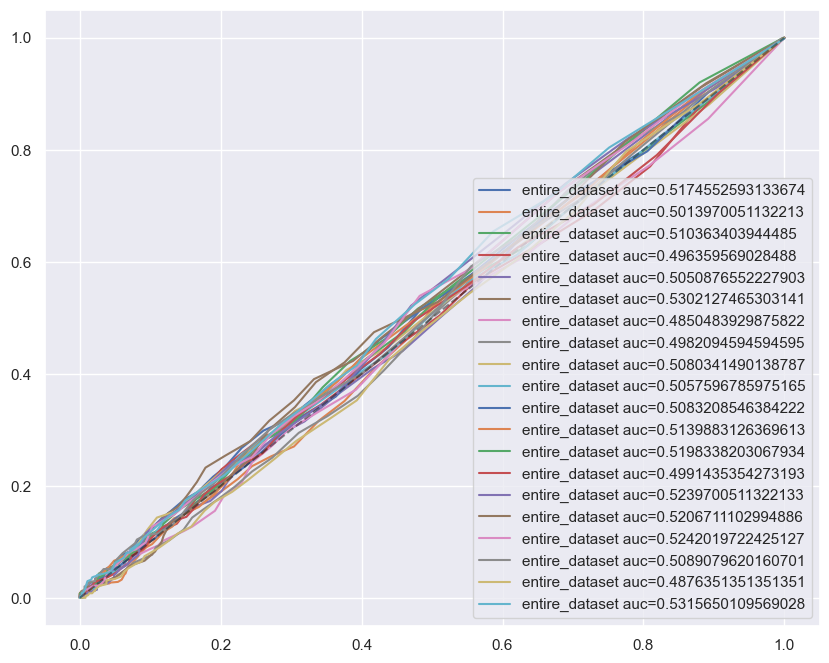

In [161]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [162]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [163]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,
orig,0.509808,0.503216,0.498434,0.490318,0.513208
syn,0.509808,0.503216,0.498434,0.490318,0.513208
dir,0.511421,0.500883,0.502861,0.492308,0.512858
rew,0.509431,0.507942,0.494624,0.495346,0.509129
egr,0.508209,0.501578,0.497094,0.486041,0.506151


<Axes: xlabel='Classifier MIA Attacks'>

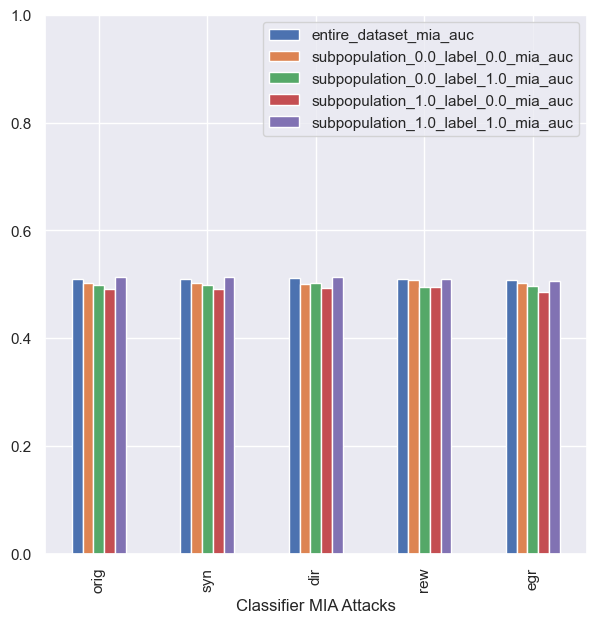

In [164]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [165]:
# Creating data structures to plot point categorical plot from seaborn

In [166]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [167]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03783783783783784],
 ['orig', 'entire_dataset', 0.03378378378378377],
 ['orig', 'entire_dataset', 0.03918918918918918],
 ['orig', 'entire_dataset', 0.03918918918918912],
 ['orig', 'entire_dataset', 0.031081081081081097],
 ['orig', 'entire_dataset', 0.058108108108108125],
 ['orig', 'entire_dataset', 0.0364864864864865],
 ['orig', 'entire_dataset', 0.03513513513513511],
 ['orig', 'entire_dataset', 0.033783783783783786],
 ['orig', 'entire_dataset', 0.027027027027027],
 ['orig', 'entire_dataset', 0.03108108108108104],
 ['orig', 'entire_dataset', 0.028378378378378366],
 ['orig', 'entire_dataset', 0.04054054054054057],
 ['orig', 'entire_dataset', 0.02837837837837831],
 ['orig', 'entire_dataset', 0.051351351351351326],
 ['orig', 'entire_dataset', 0.05675675675675673],
 ['orig', 'entire_dataset', 0.05675675675675679],
 ['orig', 'entire_dataset', 0.03648648648648645],
 ['orig', 'entire_dataset', 0.040540540540540515],
 ['orig', 'entire_dataset', 0.06756756756756754

In [168]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.037838
1,orig,entire_dataset,0.033784
2,orig,entire_dataset,0.039189
3,orig,entire_dataset,0.039189
4,orig,entire_dataset,0.031081
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.113476
496,egr,subpopulation_1.0_label_1.0,0.106799
497,egr,subpopulation_1.0_label_1.0,0.081633
498,egr,subpopulation_1.0_label_1.0,0.109466


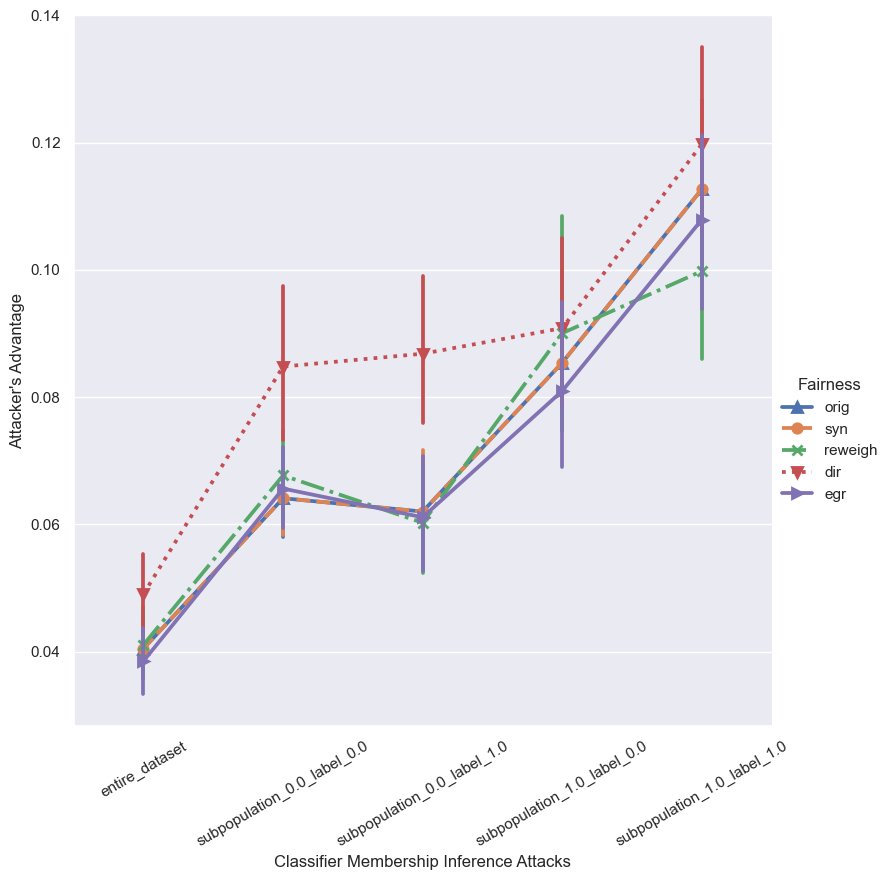

In [169]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


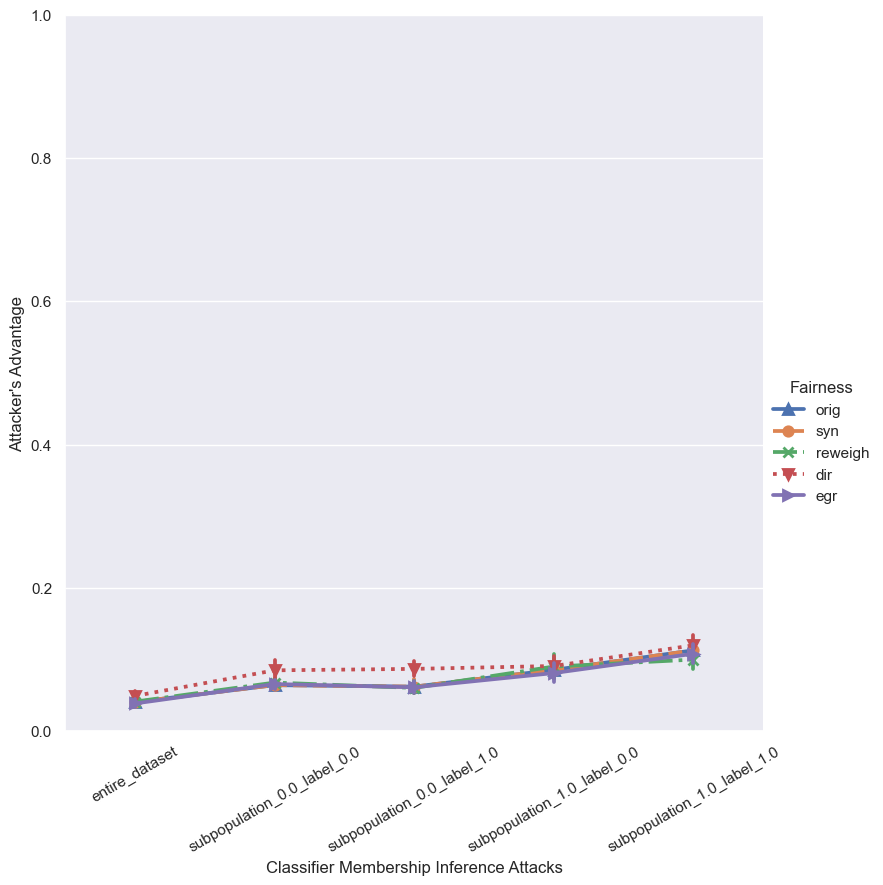

In [170]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [171]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.037838,0.053158,0.092265,0.064340,0.099481
1,0.033784,0.080887,0.086478,0.115213,0.152299
2,0.039189,0.077040,0.053752,0.094624,0.098166
3,0.039189,0.088249,0.043319,0.083550,0.073571
4,0.031081,0.049225,0.038681,0.080216,0.103224
5,0.058108,0.059758,0.075818,0.092343,0.095608
6,0.036486,0.062240,0.072358,0.097659,0.174785
7,0.035135,0.077000,0.053688,0.072171,0.066257
8,0.033784,0.057943,0.081141,0.072306,0.134921
9,0.027027,0.057657,0.051119,0.086138,0.126412


In [172]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [173]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,
orig,0.040473,0.064108,0.062010,0.085413,0.112679
syn,0.040473,0.064108,0.062010,0.085413,0.112679
dir,0.049054,0.084804,0.086822,0.090844,0.119751
rew,0.041081,0.067686,0.060251,0.090054,0.099800
egr,0.038514,0.065624,0.061109,0.080976,0.107908


<Axes: xlabel='Classifier MIA Attacks'>

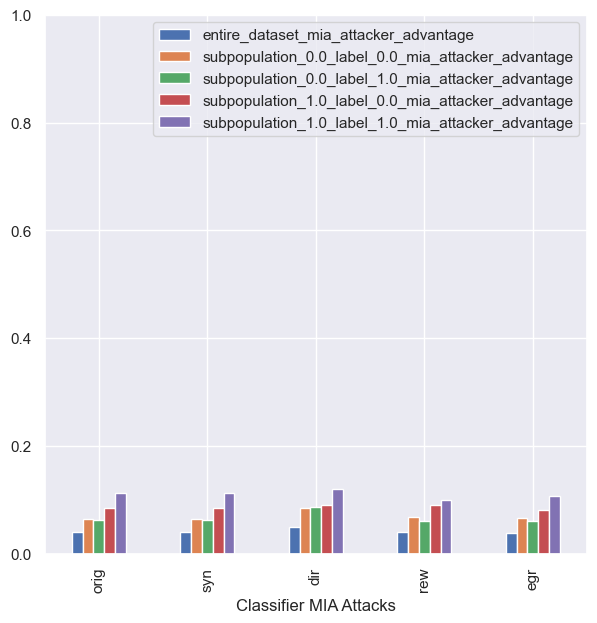

In [174]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [175]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [176]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5588235294117647],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.6666666666666666],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.8],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.8],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 1.0],
 ['orig', 'entire_dataset', 0.506872852233677],
 ['orig', 'entire_dataset', 0.75],
 ['orig', 'subpopulation_0.0_label_0.0', 1.0],
 ['orig', 'subpopulation_0.0_label_0.0', 1.0],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5833333333333334],
 ['orig', 'subpopulation_0.0_label_0.0', 1.0],
 ['orig', 'subpopulation_0.0_label_0.0', 0.75],
 ['orig', 'subpopulation

In [177]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.558824
1,orig,entire_dataset,1.000000
2,orig,entire_dataset,0.666667
3,orig,entire_dataset,1.000000
4,orig,entire_dataset,1.000000
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.600000
496,egr,subpopulation_1.0_label_1.0,0.500000
497,egr,subpopulation_1.0_label_1.0,1.000000
498,egr,subpopulation_1.0_label_1.0,0.727273


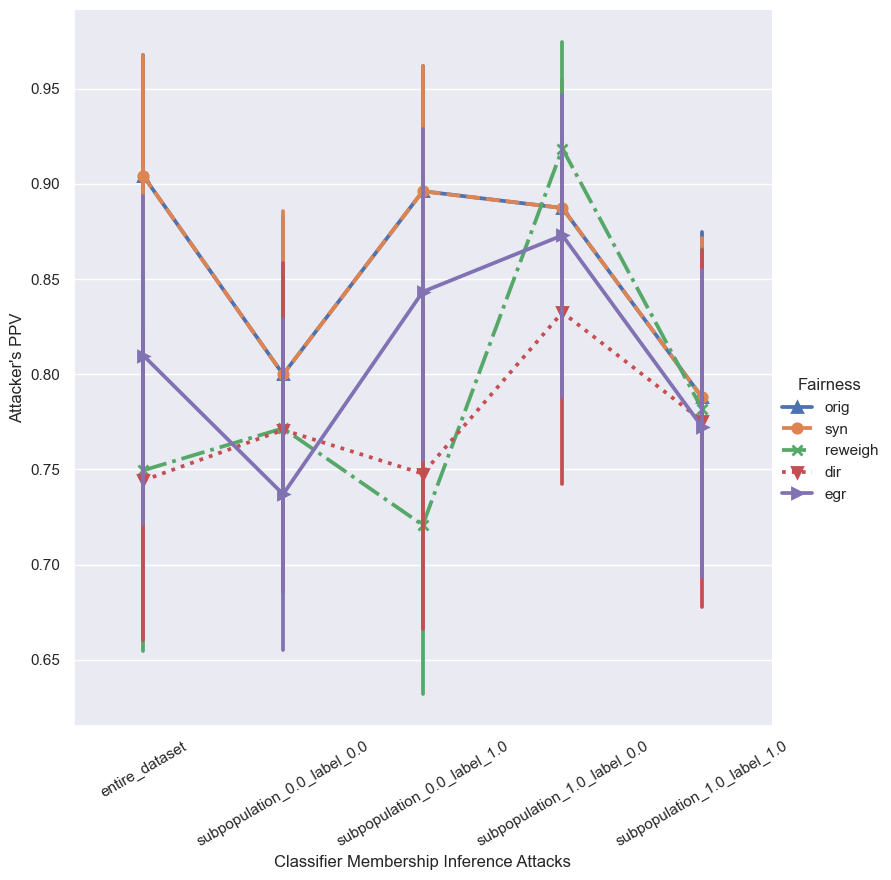

In [178]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
